# GANの気持ち

- VAEの問題
    - 尤度関数を設定することによって，生成される画像がぼやける．
- GANでの解決策
    - 尤度関数を置かなければいい．データ分布にモデル分布を近似したいのだから，密度比で十分．
    - 式変形
    - それは，結局識別器を使って，データ分布とモデル分布の距離を求める問題に落ちてくる．

課題 VAEの生成は画像がぼやけてしまう．

理由
- 確率分布を明示的にモデル化するため．

$p(x|z)$をガウス分布とした時，再構成誤差がが二乗誤差になる．\
ぼやかしたほうが，再構成誤差が小さくなるって仕組みがある．(分散を小さくすればぼやけなくなるけど，生成されるデータが偏る，)

- 最尤学習

最尤学習では，訓練データになり部分に高い確率を置くように訓練しがち．

結論

目的関数や，確率分布の置き方でぼやけたりする．

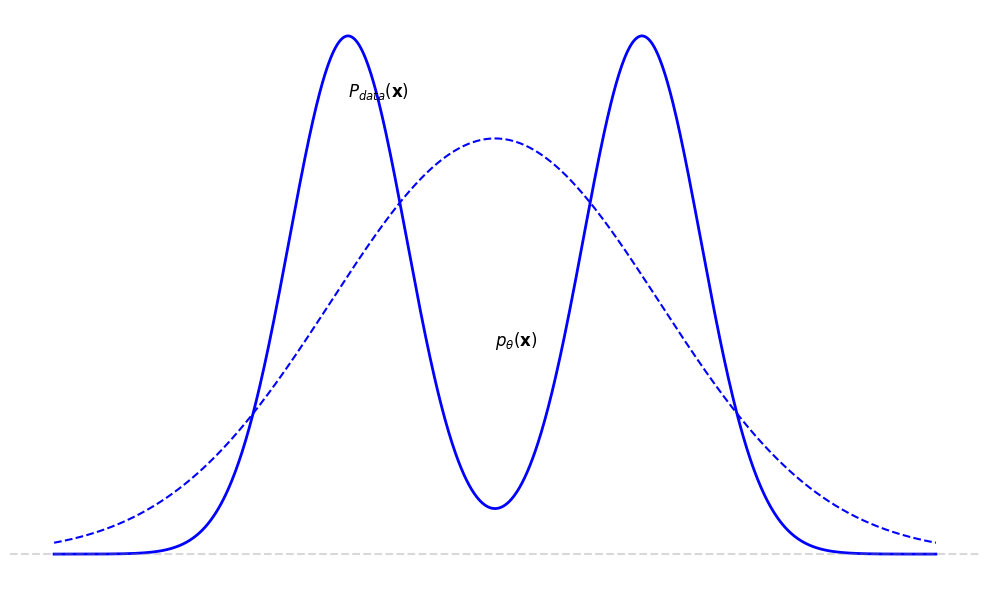

In [13]:
# 訓練データにない部分に高い確率を置くとはこういうこと．

import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Create x values
x = np.linspace(-6, 6, 1000)

# Create the bimodal distribution (P_data)
def bimodal(x, mu1=-2, mu2=2, sigma=1, w1=0.5, w2=0.5):
    y1 = np.exp(-0.5 * ((x - mu1) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    y2 = np.exp(-0.5 * ((x - mu2) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return w1 * y1 + w2 * y2

# Generate P_data(x) - the solid line with multiple peaks
p_data = bimodal(x, mu1=-2, mu2=2, sigma=0.8, w1=0.5, w2=0.5)

# Generate p_g(x) - the dashed line
p_g = 0.2 * np.exp(-0.1 * x**2)

# Plot the curves
plt.plot(x, p_data, 'blue', linewidth=2, label='$P_{data}(\\mathbf{x})$')
plt.plot(x, p_g, 'blue', linestyle='--', linewidth=1.5, label='$p_g(\\mathbf{x})$')
# Remove axes ticks

plt.xticks([])
plt.yticks([])

# Add labels
plt.text(-2, 0.22, '$P_{data}(\\mathbf{x})$', fontsize=12)
plt.text(0, 0.1, '$p_{\\theta}(\\mathbf{x})$', fontsize=12)

# Remove box
plt.box(False)

# Show horizontal dashed line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

対策

確率分布を置かなければ良い．尤度関数を置かないってこと．

尤度が計算できないので，データ分布と，モデル分布の違い自体を求める．

尤度関数というクッションを挟まず，直接求めるってこと．

具体的には，データ分布とモデル分布の密度差や密度比を求める．(密度比=1であれば，モデル分布はデータ分布を十分近似できたことになる．)

データ集合のうち，データ分布から得られたものに，$y=1$，モデル分布から得られたものに$y=0$のラベルをつける．

本物ラベルと偽物ラベルをつけるってことだね．

$$
p_{data}(x) = p(x|y=1)\\
p_{\theta}(x) = p(x|y=0)
$$



KLダイバージェンスは非対称なので，距離関数として扱えない．

ジェンセンシャノンダイバージェンスは対称なので，距離関数として扱える．

ここまでで，データ分布に近いモデル分布が求められたがどうかは，識別器をつかって識別できるかを見てあげればいいことがわかる．

では，識別器はどのようにモデリングするの？

- 識別器のモデリング
    - 識別器はのモデリングは，データ分布とモデル分布の距離という解釈．つまり，識別器のモデル式のなかに生成器が入ってくる．
    - 生成器のモデリング
        - 生成器をニューラルネットワークでモデリングする．
    - これで得られた生成器を使って識別器を学習する．
    - その後，また生成器を学習する．
    - これを繰り返す．(目的関数を交互に最適化する．)
これがGAN(Generative Adversarial Networks)

わかった通り，GANは生成器と識別器の2つのモデルを使って学習する．

つまり，最適な生成器が得られないと，最適な識別器が得られない．逆も然り．

生成器のパラメータについては最小化，識別器のパラメータについては最大化．

$G$は生成器，$D$は識別器．
$$
\min_{\theta} \max_{\phi} L(G_{\theta}, D_{\phi})
$$

- GANの課題
    - 収束性(振動する) 結構いつも機械学習で見てるような問題だし，それの解決策って感じ．(オプティマイザの工夫，正則化...)
        - Optimistic Gradient Descent Ascent
        - Regularization Gradient Descent Ascent
        - Overparameterization
    - モード崩壊(生成器がデータ分布の一部しか生成できないこと．)
        - Minibatch discrimination
        - Unrolled GAN
        - AdaGAN
        - Two Time-Scale Update Rule
        - Wasserstein GAN
    - 勾配消失問題

GANの目標は，二つのパラメータがいい感じになるところを求めること．\
そのような状況をナッシュ均衡という．

勾配消失問題

目的関数をいじることで，勾配消失を防ぐ．(略)\
もはやジェンセンシャノンダイバージェンスの最小化ではなくなるけど．

GANのジレンマ．

- 識別器が十分に学習できていないうちに生成器を最適化すると，モード崩壊が起きる．
- 生成器が十分に学習できていないうちに識別器を最適化すると，勾配消失が起きる．(どの方向にパラメータを更新すれば識別器を騙すような生成器が得られるかわからないから．)

- 様々なGAN
    - Conditional GAN
        - yで条件付けたGAN，VAEでも同じようなのあったね．
        - 文章で条件，画像で条件など...
    - InfoGAN
        - 潜在変数の一部を条件として使う．
        - 相互情報量の下界を正則化項として目的関数に加える．すると，暗黙的に潜在変数の一部が条件として使われ，条件として潜在変数が獲得できる．
        - 潜在変数zはガウスノイズだけど，条件として獲得できる潜在変数は，何かしらの意味のあるものが獲得できるってこと．(多分)
    - ACGAN
        - 綺麗な画像は識別性も高いはず．
        - 画像が本物か偽物かだけでなく，クラスも識別してあげれば，もっと明瞭な画像が生成できる生成器が獲得できるのでは．
        - クラスラベルという一種の条件付けになる．
    - GANのダイバージェンスの変更．
        - KLダイバージェンスから解放されているので，他のダイバージェンスを使っても良いのでは？

- ジェンセンシャノンダイバージェンスの課題
    - 分布の台(support)が交わらないと，識別器は完全に識別できてしまう→勾配消失
- ワッサーシュタイン距離
    - 分布が近づくにつれて距離も小さくなる．

- Wasserstein GAN
- SN-GAN(スペクトル正規化)
- SA-GAN(self-attention)

GANの評価方法

教師あり学習であれば，正解ラベルがあるので，正解ラベルとの距離を求めればいい．

GANは教師なし学習なので，正解ラベルがない．→自明ではない．

よくある方法は，テストデータに対する尤度を評価する．(VAEはね．)
(ELBOを計算するだけ．)

でも，GANは尤度関数をつかわないので，この方法は使えない．

どうやって評価すればいい？

そもそも良い生成画像って何かっていう議論があるよね．(VAEのように尤度を最大化しても，ぼやけた画像しか出てこない．)

- 良い生成器
    - 高い信念で識別できる．→$p(y|x)$のエントロピーが小さい．
    - バリエーションが豊富．→$P(y)$のエントロピーが高い．

これを評価する指標が，Inception Score

人間の評価と相関する．

Inceotion Scoreの応用
- FID(Frechet Inception Distance)

GANの応用
- Progressive GAN
- BigGAN
- Image-to-Image Translation
    - Pix2Pix
    - BicycleGAN
    - CycleGAN
        - sim2real
            - RL-CycleGAN
            - RetinaGAN
    - StarGAN

### わかんないところ

VAEも識別問題に持っていっている．え．そうなの？

KLダイバージェンスの非対称性の解釈．

overparameterized？？？？？

誕生日のパラドックスのようなことが起きていて，ランダムサンプリングしていても，意外とデータに偏りがあって分布を学習できていないんじゃないか．\
んで確認してみたら，400サンプルのうち，少なくとも1つ以上重複がある確率が50%以上だった．はわかる．\
このGANが生成できる画像の種類はおよそ$400^2=160000$になる．←わからない．\
重複がないという話なら，全ての通り，同時分布で考えて，$400^2$通りになるのは理解できる．でも重複があるからそれより少なくなるんじゃないの？


勾配消失の対策に，生成器の目的関数をいじるけど，それでなぜ勾配消失が解消されるのかわからない．\
ただ符号を変えたり，ちょっと変えただけなのに．

InfoGANで，暗黙的に潜在変数を導入することで条件を獲得するってことだけど．\
条件付けるというよりは，潜在変数として，条件が入るような入れ物を作ってあげるってことをしてるんじゃないの？
だから意図した条件が入るかどうかはデータの質によりそう．\
てかそもそも条件なんて単語出てきてないか．

ワッサーシュタイン距離とKLダイバージェンスの違いがわからない．\
KLダイバージェンスは非対称だから，距離関数として扱えない．\
ワッサーシュタイン距離は対称だから，距離関数として扱える．ってこと？？？

スペクトルノルム

リプシッツ連続性

